In [91]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [92]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [93]:
@njit()
# @jit(nopython=True)
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(0.05)
    step_vol.append(0.05)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [94]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [95]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [96]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [97]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [98]:
@njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 1.01156918 -0.02584338]
The function value of pqbest:		1.1818934347559136
Algorithm running time:			5.142208099365234 s


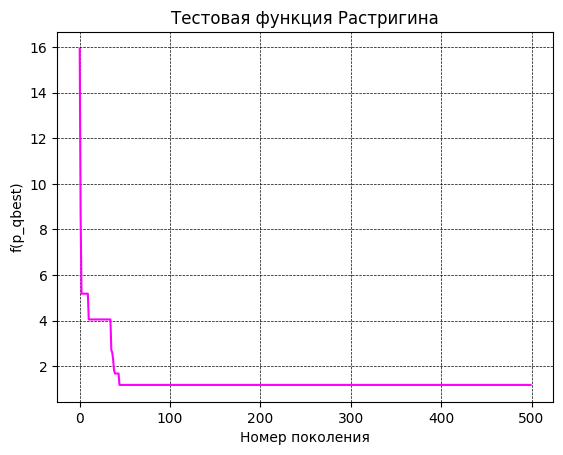

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 1.01624037 -1.00296137]
The function value of pqbest:		2.0924239117779138
Algorithm running time:			0.031209707260131836 s


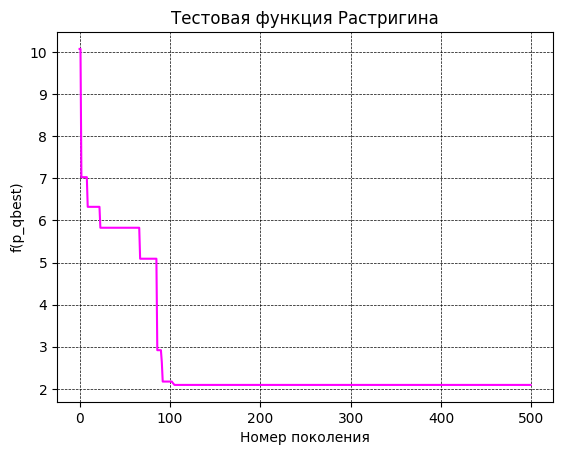

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.99771808 0.01024818]
The function value of pqbest:		1.0172982036595002
Algorithm running time:			0.03998756408691406 s


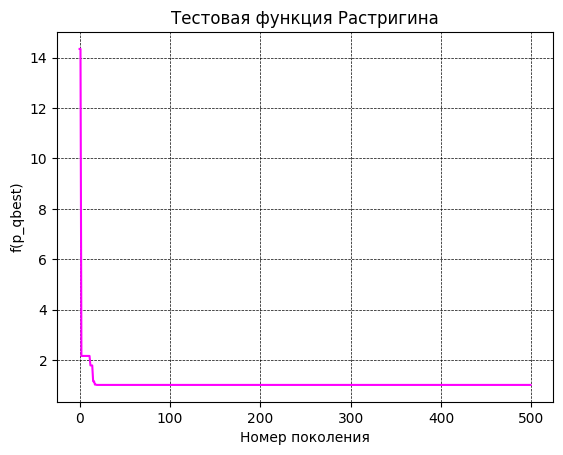

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.03283547 0.01165945]
The function value of pqbest:		0.2401041352826141
Algorithm running time:			0.03200340270996094 s


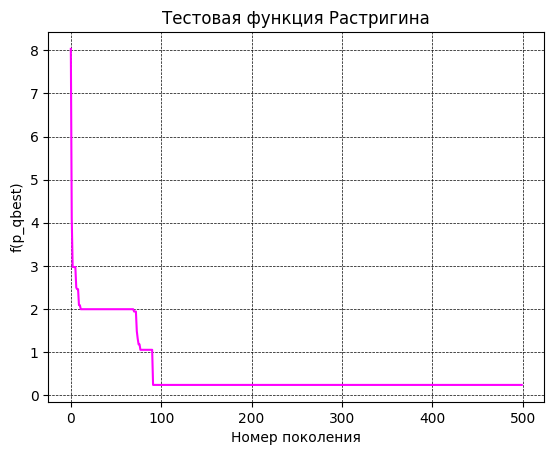

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.00321384 0.99900199]
The function value of pqbest:		1.0002506452060977
Algorithm running time:			0.03200244903564453 s


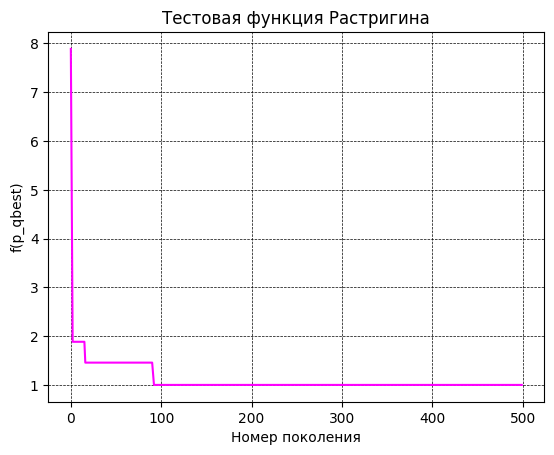

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.97612799 -0.00456552]
The function value of pqbest:		1.0692385041161891
Algorithm running time:			0.056005239486694336 s


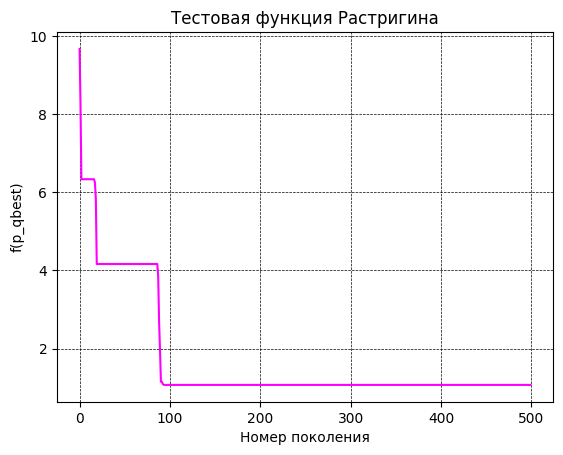

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.0479023   1.02820927]
The function value of pqbest:		1.6657082361920281
Algorithm running time:			0.032003164291381836 s


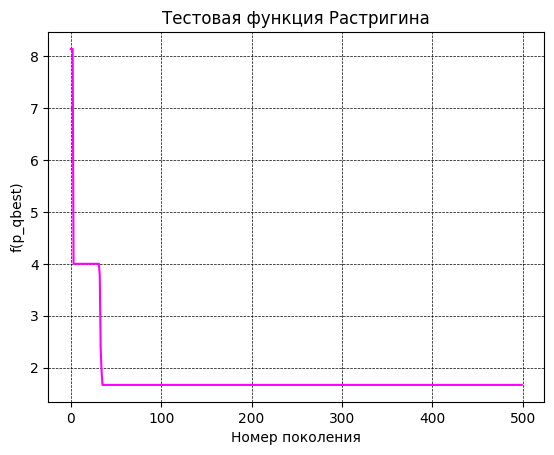

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-1.00396685  0.01929128]
The function value of pqbest:		1.0847978106219145
Algorithm running time:			0.03998923301696777 s


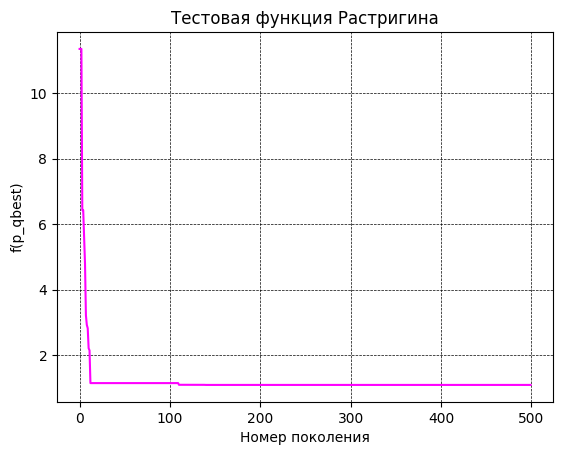

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-2.00174801 -1.01681135]
The function value of pqbest:		5.097238986892558
Algorithm running time:			0.04802107810974121 s


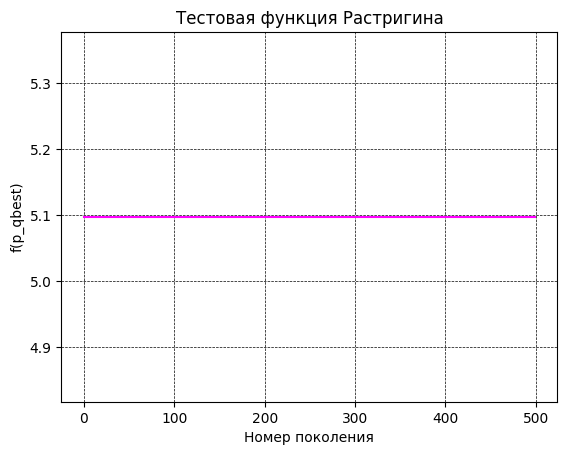

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.04218148 -0.02239934]
The function value of pqbest:		0.45031932538199015
Algorithm running time:			0.04001331329345703 s


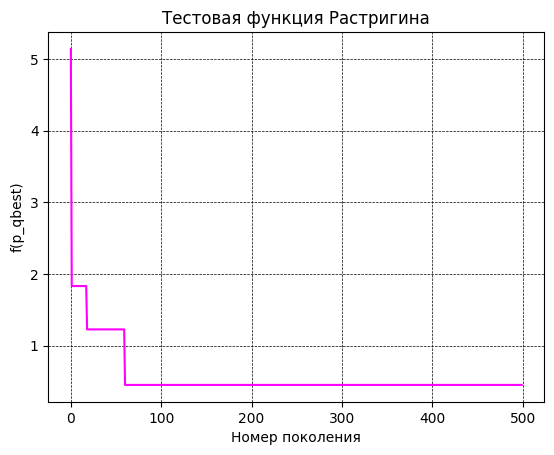

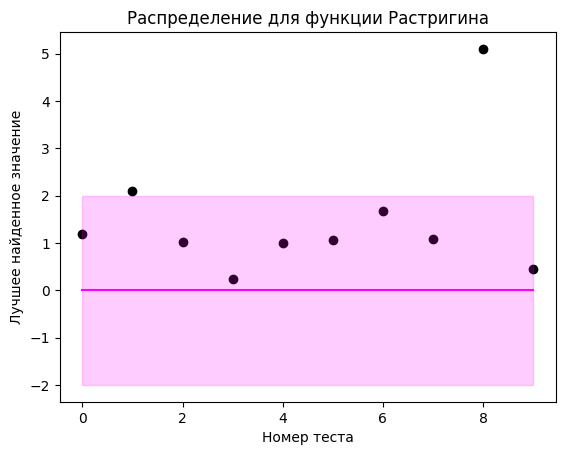

In [99]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [100]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [101]:
@njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5, 5, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 1.00088128 -0.00254706]
The function value of pqbest:		2.6398977163635244
Algorithm running time:			0.04002070426940918 s


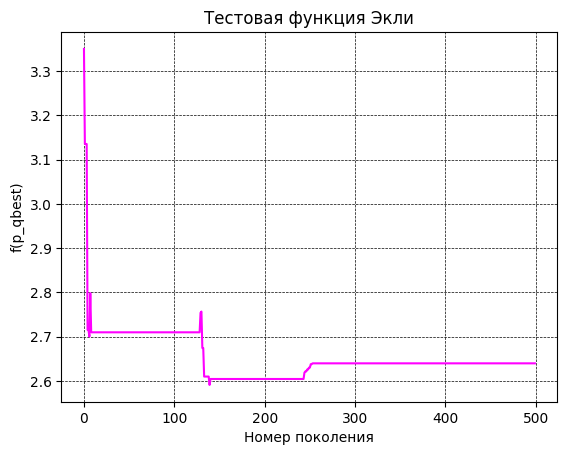

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.98902484 -0.01737092]
The function value of pqbest:		2.622230797220414
Algorithm running time:			0.03229880332946777 s


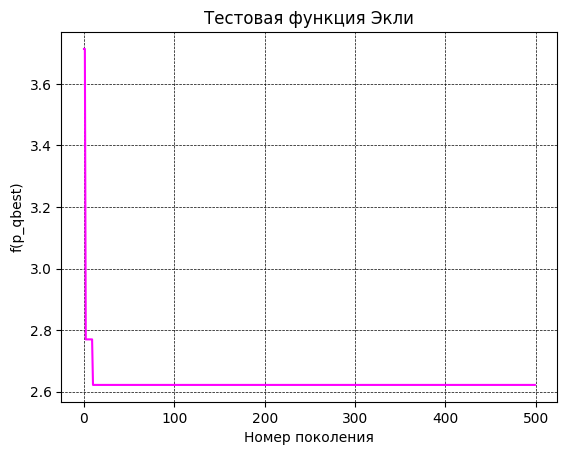

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-1.97899391  0.03132773]
The function value of pqbest:		4.92072123989599
Algorithm running time:			0.02398967742919922 s


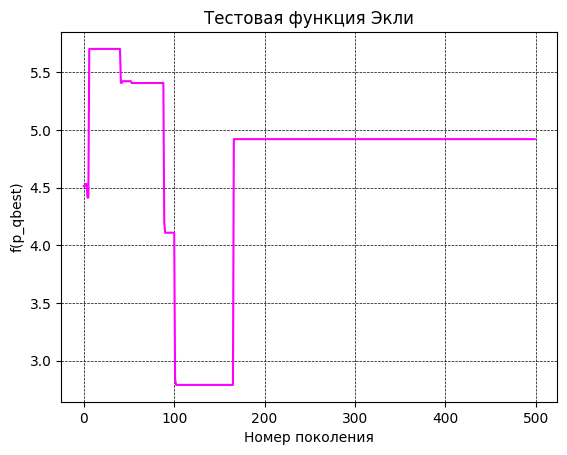

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.02319578 -0.02788115]
The function value of pqbest:		0.13730435588496093
Algorithm running time:			0.023998737335205078 s


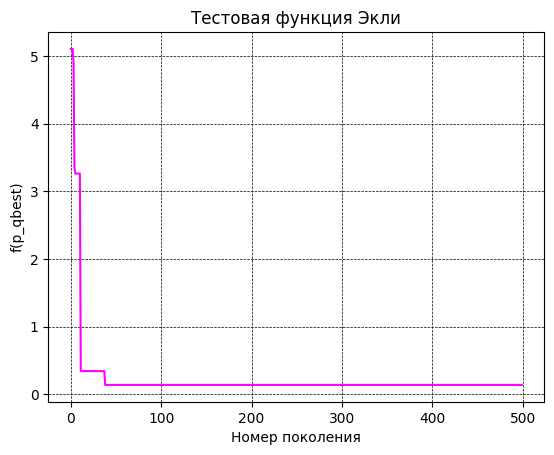

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.96883517  0.98102526]
The function value of pqbest:		3.578529148141648
Algorithm running time:			0.02400994300842285 s


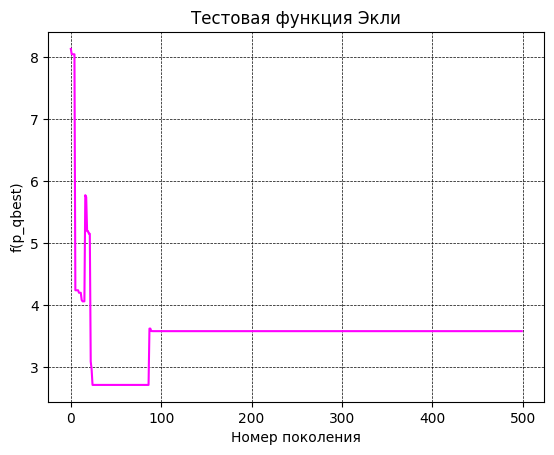

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.03073898 0.92861861]
The function value of pqbest:		2.6177265677847075
Algorithm running time:			0.0240023136138916 s


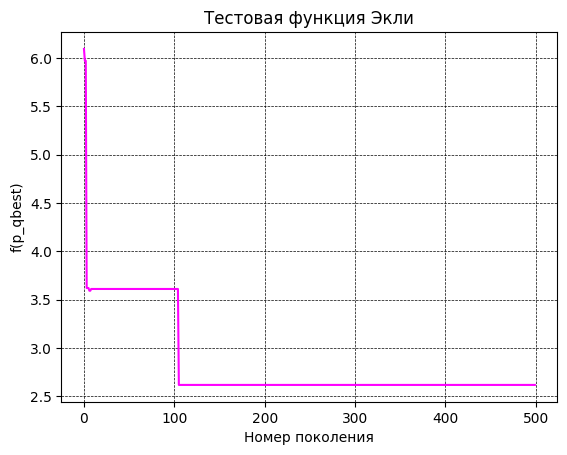

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.94680925 0.05521438]
The function value of pqbest:		2.6621834215486544
Algorithm running time:			0.02399730682373047 s


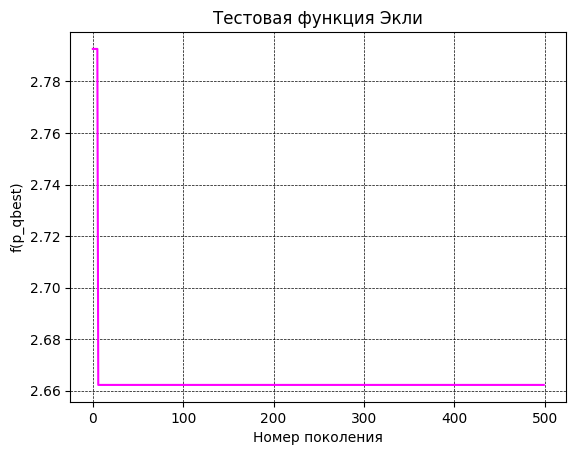

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.05068061 -0.0415844 ]
The function value of pqbest:		0.29665035838262455
Algorithm running time:			0.016013622283935547 s


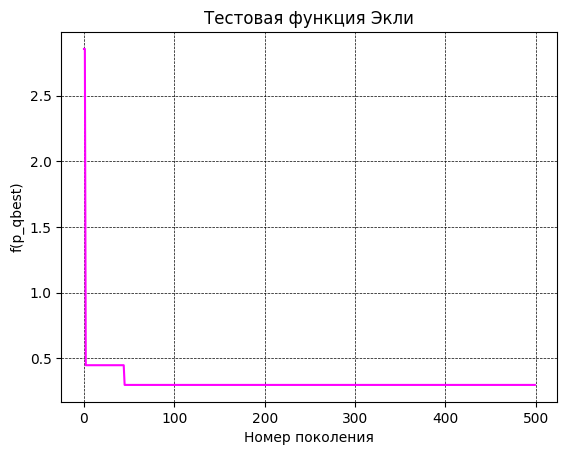

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 2.1008197  -0.00730279]
The function value of pqbest:		5.393256574696927
Algorithm running time:			0.02401566505432129 s


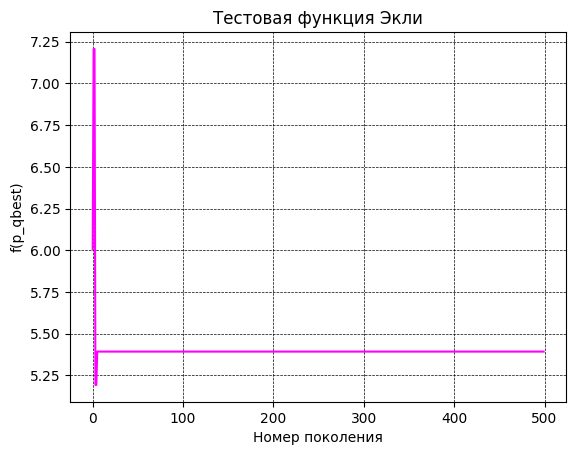

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.01525994 -0.03378667]
The function value of pqbest:		0.14108982512476587
Algorithm running time:			0.023995161056518555 s


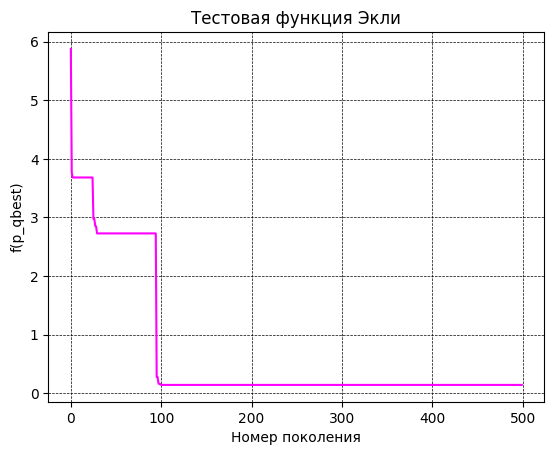

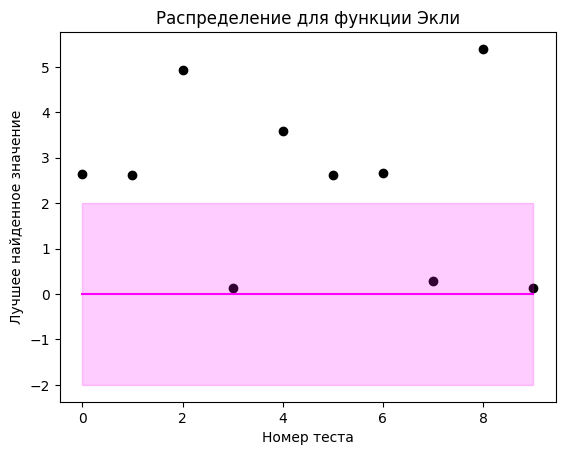

In [102]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [103]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [104]:
@njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-10, 10, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.99368366 -0.97996821]
The function value of pqbest:		1.9477449103703406
Algorithm running time:			0.02400350570678711 s


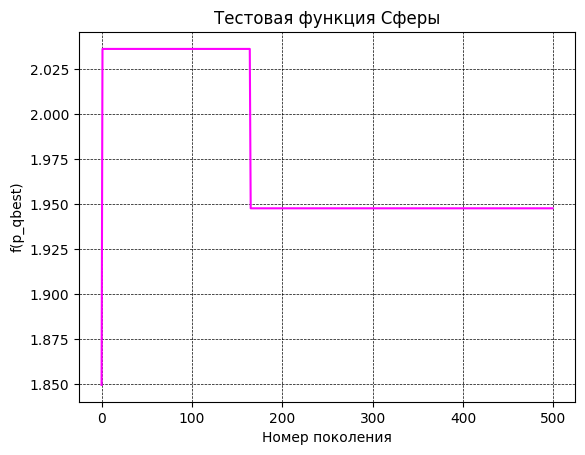

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.05235899 -0.00863482]
The function value of pqbest:		0.002816023403944754
Algorithm running time:			0.024014949798583984 s


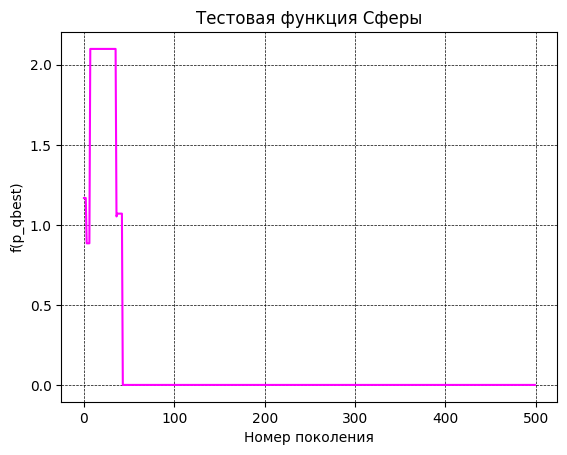

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 7.79111668e-04 -9.69950293e-01]
The function value of pqbest:		0.9408041781073135
Algorithm running time:			0.0240018367767334 s


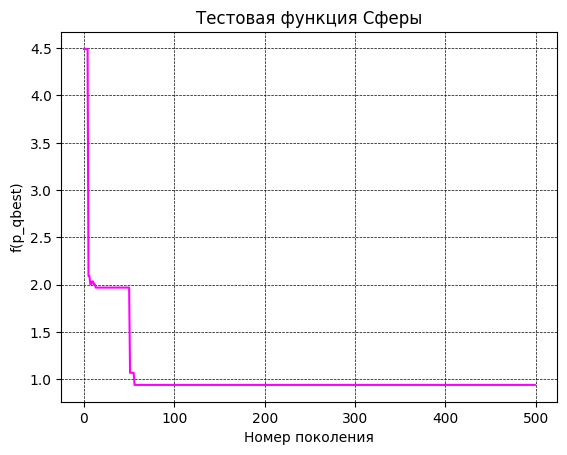

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.11587538 0.93748559]
The function value of pqbest:		0.8923063320685694
Algorithm running time:			0.023997783660888672 s


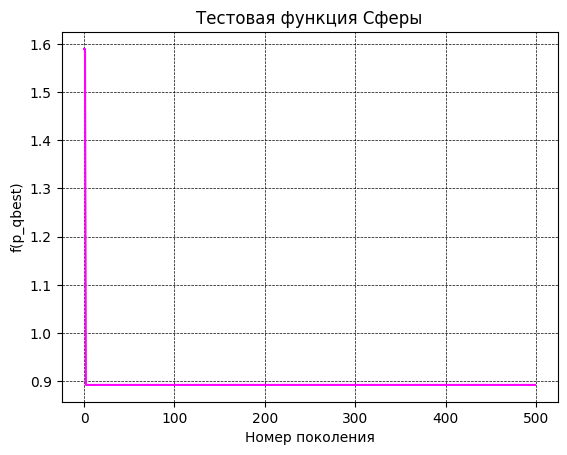

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.95068048 0.00784296]
The function value of pqbest:		0.9038548957954573
Algorithm running time:			0.024005651473999023 s


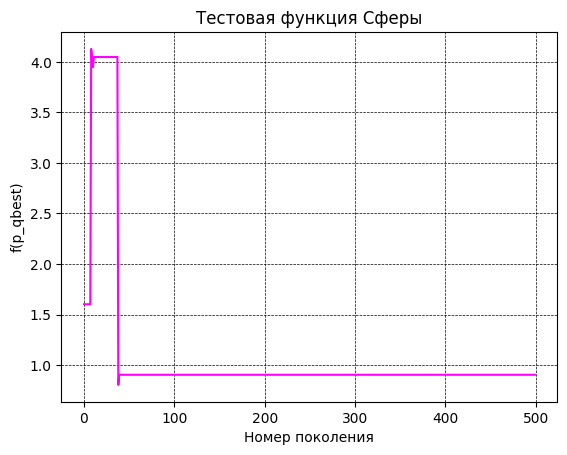

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.02228744  1.01965689]
The function value of pqbest:		1.0401968934166166
Algorithm running time:			0.024509429931640625 s


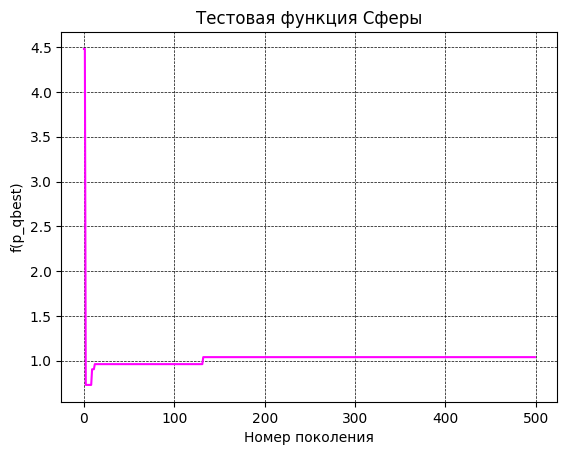

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.00012674  0.0681899 ]
The function value of pqbest:		0.0046498791719795166
Algorithm running time:			0.016014575958251953 s


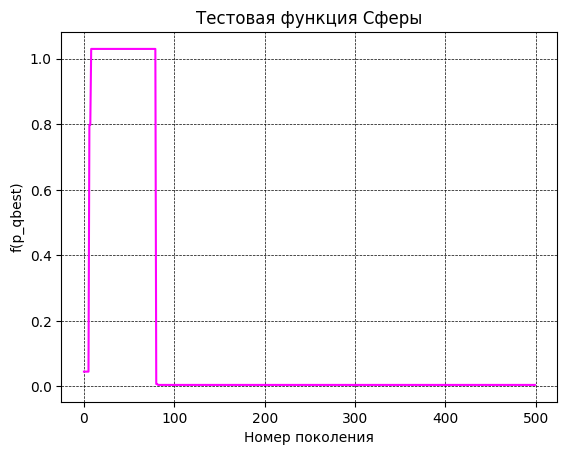

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.98243706 1.01189661]
The function value of pqbest:		1.9891173200292367
Algorithm running time:			0.024003267288208008 s


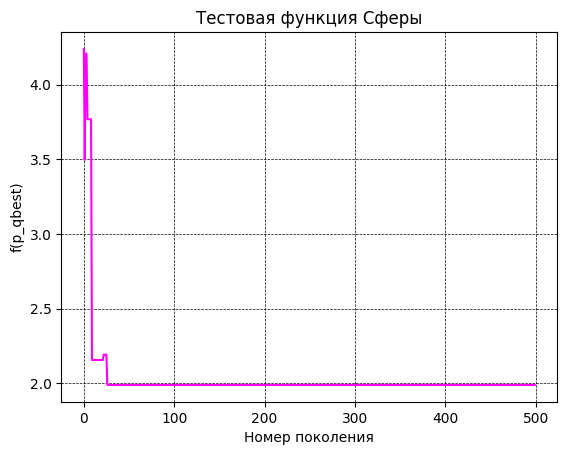

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-1.97762399 -0.99985374]
The function value of pqbest:		4.910704141609974
Algorithm running time:			0.01598668098449707 s


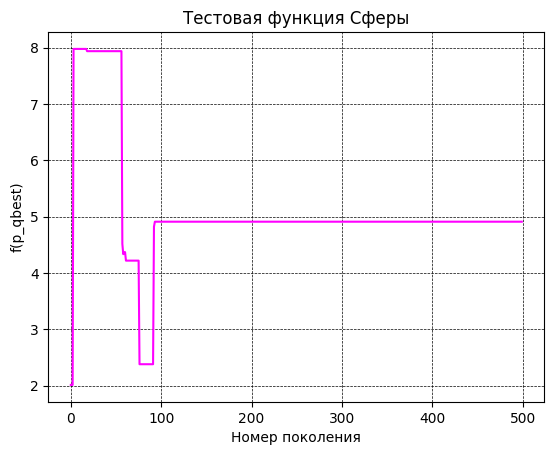

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-1.00922535 -1.02806137]
The function value of pqbest:		2.075446003535615
Algorithm running time:			0.0240020751953125 s


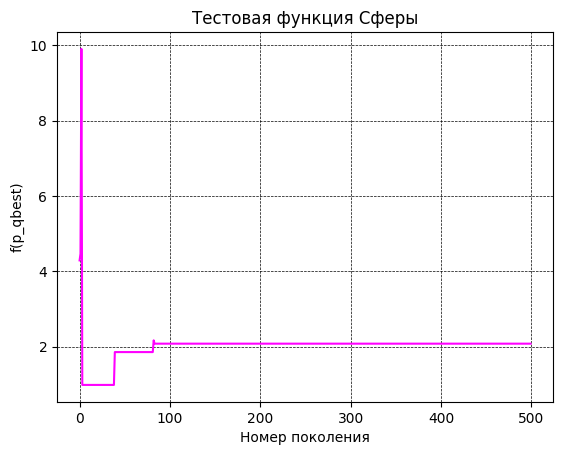

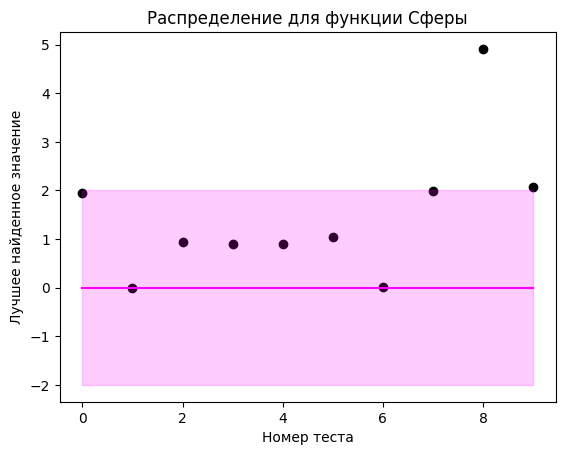

In [105]:
start_test("Сферы")
